In [3]:
!pip install gym[atari,accept-rom-license]==0.25.2
import sys, os
import gym
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
import torch
import torchvision
import numpy as np
import random
from gym.spaces import Box
from collections import deque


class SkipFrame(gym.Wrapper):
    def __init__(self, env, skip):
        super().__init__(env)
        self._skip = skip

    def step(self, action):
        total_reward = 0.0
        done = False
        for i in range(self._skip):
            obs, reward, done, info = self.env.step(action)
            total_reward += reward
            if done:
                break
        return obs, total_reward, done, info


class GrayScaleObservation(gym.ObservationWrapper):
    def __init__(self, env):
        super().__init__(env)
        obs_shape = self.observation_space.shape[:2]
        self.observation_space = Box(low=0, high=255, shape=obs_shape, dtype=np.uint8)

    def observation(self, observation):
        observation = np.transpose(observation, (2, 0, 1))
        observation = torch.tensor(observation.copy(), dtype=torch.float)
        transform = torchvision.transforms.Grayscale()
        observation = transform(observation)
        return observation


class ResizeObservation(gym.ObservationWrapper):
    def __init__(self, env, shape):
        super().__init__(env)
        self.shape = (shape, shape) if isinstance(shape, int) else tuple(shape)
        obs_shape = self.shape + self.observation_space.shape[2:]
        self.observation_space = Box(low=0, high=255, shape=obs_shape, dtype=np.uint8)

    def observation(self, observation):
        transforms = torchvision.transforms.Compose([torchvision.transforms.Resize(self.shape),
                                                     torchvision.transforms.Normalize(0, 255)])
        return transforms(observation).squeeze(0)


class ExperienceReplayMemory(object):
    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)

    def __len__(self):
        return len(self.memory)

    def store(self, state, next_state, action, reward, done):
        state = state.__array__()
        next_state = next_state.__array__()
        self.memory.append((state, next_state, action, reward, done))

    def sample(self, batch_size):
        # TODO: uniformly sample batches of Tensors for: state, next_state, action, reward, done
        # ...


        # uniformly get batch with batch_size
        sampled_batch = random.sample(self.memory, batch_size)

        states = []
        next_states = []
        actions = []
        rewards = []
        dones = []

        # save to arrays
        for (curr_state, next_state, action, reward, done) in sampled_batch:
            states.append(curr_state)
            next_states.append(next_state)
            actions.append(action)
            rewards.append(reward)
            dones.append(done)


        return  torch.tensor(np.array(states)), \
                torch.tensor(np.array(next_states)), \
                torch.tensor(np.array(actions)), \
                torch.tensor(np.array(rewards)), \
                torch.tensor(np.array(dones))


In [36]:
import torch
import gym
import numpy as np
import copy
from gym.wrappers import FrameStack
from sklearn.metrics import mean_squared_error


env_rendering = False    # Set to False while training your model on Colab
testing_mode = False
test_model_directory = './your_saved_model.pth.tar'

# Create and preprocess the Space Invaders environment
if env_rendering:
    env = gym.make("ALE/SpaceInvaders-v5", full_action_space=False, render_mode="human")
else:
    env = gym.make("ALE/SpaceInvaders-v5", full_action_space=False)
env = SkipFrame(env, skip=4)
env = GrayScaleObservation(env)
env = ResizeObservation(env, shape=84)
env = FrameStack(env, num_stack=4)
image_stack, h, w = env.observation_space.shape
num_actions = env.action_space.n
print('Number of stacked frames: ', image_stack)
print('Resized observation space dimensionality: ', h, w)
print('Number of available actions by the agent: ', num_actions)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

seed = 61
env.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
if torch.backends.cudnn.enabled:
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

# Hyperparameters (to be modified)
batch_size = 32
alpha = 0.00025
gamma = 0.95
eps, eps_decay, min_eps = 1.0, 0.999, 0.05
buffer = ExperienceReplayMemory(20000)
burn_in_phase = 20000
sync_target = 30000
max_train_frames = 10000
max_train_episodes = 1000# 100000
max_test_episodes = 1
curr_step = 0
learning_rate = 0.001


Number of stacked frames:  4
Resized observation space dimensionality:  84 84
Number of available actions by the agent:  6
cuda


/usr/local/lib/python3.8/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.8/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


In [6]:

def convert(x):
    return torch.tensor(x.__array__()).float()


class DeepQNet(torch.nn.Module):
    def __init__(self, h, w, image_stack, num_actions):
        super(DeepQNet, self).__init__()
        # TODO: create a convolutional neural network
        # ...

        self.conv = torch.nn.Sequential(
            torch.nn.Conv2d(4, 6, 5),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(2,2),
            torch.nn.Conv2d(6,16,5),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(2,2)
        )

        self.out_size = self.get_out(h,w)
        self.fully_connected_layers = torch.nn.Sequential(
            torch.nn.Linear(self.out_size, 128),
            torch.nn.Linear(128, 64),
            torch.nn.Linear(64, num_actions)
        )

    def get_out(self, h,w):
        out = self.conv(torch.zeros(1, 4, h, w))
        return int(np.prod(out.size()))

    def forward(self, x):
        # TODO: forward pass from the neural network
        # ...
        x_new = self.conv(x)
        x_new = x_new.view(-1, self.out_size)
        return self.fully_connected_layers(x_new)



# TODO: create an online and target DQN (Hint: Use copy.deepcopy() and requires_grad utilities!)
# ...
online_dqn = DeepQNet(h,w,image_stack, num_actions)
target_dqn = copy.deepcopy(online_dqn)
online_dqn.to(device)
target_dqn.to(device)


# TODO: create the appropriate MSE criterion and Adam optimizer
# ...
optimizer = torch.optim.Adam(online_dqn.parameters(), lr=learning_rate)
criterion = torch.nn.MSELoss()


In [34]:
import torch

def policy(state, is_training):
    global eps
    state = convert(state).unsqueeze(0).to(device)

    #TODO: Implement an epsilon-greedy policy
    #...
    with torch.no_grad():
        if is_training:
            p = online_dqn(state)
            if np.random.rand() < eps:
                a = random_action()
            else:
                a = torch.argmax(p).tolist()

        else:
            p = online_dqn(state)
            a = torch.argmax(p).tolist()

    return a

def random_action():
    return np.random.randint(0, num_actions)

def compute_loss(state, action, reward, next_state, done):
    state = convert(state).to(device)
    next_state = convert(next_state).to(device)
    action = action.to(device)
    reward = reward.to(device)
    done = done.to(device)

    # TODO: Compute the DQN (or DDQN) loss based on the criterion
    # ...

    # mse loss

    target = target_dqn(next_state)
    pred = online_dqn(state)
    
    pred_next_state = online_dqn(next_state)
    counter = 0
    diff_squared = 0
    for st,at,rt,news_t,dt in zip(state, action, reward, next_state, done):
        action_max_q = torch.argmax(pred_next_state[counter])

        y_target = rt + gamma * target[counter][action_max_q]
        diff_squared += (y_target - pred[counter])**2
    # huberloss
    # loss = torch.nn.SmoothL1Loss().to(device)
    loss = torch.sum(diff_squared) / torch.flatten(pred).size()[0]
    return loss


def run_episode(curr_step, buffer, is_training):
    global eps
    global target_dqn
    episode_reward, episode_loss = 0, 0.
    state = env.reset()
    
    for t in range(max_train_frames):
        action = policy(state, is_training)
        curr_step += 1
        next_state, reward, done, _ = env.step(action)
        episode_reward += reward

        if is_training:
            buffer.store(state, next_state, action, reward, done)

            if curr_step > burn_in_phase:
                state_batch, next_state_batch, action_batch, reward_batch, done_batch = buffer.sample(batch_size)

                if curr_step % sync_target == 0:
                    # TODO: Periodically update your target_dqn at each sync_target frames
                    # ...
                    target_dqn = copy.deepcopy(online_dqn)

                loss = compute_loss(state_batch, action_batch, reward_batch, next_state_batch, done_batch)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                episode_loss += loss.item()

        else:
            with torch.no_grad():
                episode_loss += compute_loss(state, action, reward, next_state, done).item()

        state = next_state

        if done:
            break
    

    return dict(reward=episode_reward, loss=episode_loss / t), curr_step


In [8]:
def update_metrics(metrics, episode):
    for k, v in episode.items():
        metrics[k].append(v)


def print_metrics(it, metrics, is_training, window=100):
    reward_mean = np.mean(metrics['reward'][-window:])
    loss_mean = np.mean(metrics['loss'][-window:])
    mode = "train" if is_training else "test"
    print(f"Episode {it:4d} | {mode:5s} | reward {reward_mean:5.5f} | loss {loss_mean:5.5f}")


def save_checkpoint(curr_step, eps, train_metrics):
    save_dict = {'curr_step': curr_step, 
                 'train_metrics': train_metrics, 
                 'eps': eps,
                 'online_dqn': online_dqn.state_dict(), 
                 'target_dqn': target_dqn.state_dict()}
    torch.save(save_dict, test_model_directory)


In [9]:
# TODO: Plot your train_metrics and test_metrics
# ...
def plot_metrics(metrics, window=100):
    reward = metrics['reward'][-window:]
    loss = metrics['loss'][-window:]
    epsiodes = np.arange(0, max_train_episodes, 1)

    fig, (ax1, ax2) = plt.subplots(1, 2)
    ax1.plot(epsiodes, reward)
    ax2.plot(epsiodes, loss)

    ax1.set_xlabel("episodes")
    ax2.set_xlabel("episodes")
    ax1.set_ylabel("reward")
    ax2.set_ylabel("loss")

    plt.tight_layout()
    plt.show()
    # plt.savefig("test.png")

/usr/local/lib/python3.8/dist-packages/gym/utils/passive_env_checker.py:227: DeprecationWarning: WARN: Core environment is written in old step API which returns one bool instead of two. It is recommended to rewrite the environment with new step API. 
  logger.deprecation(


Episode    0 | train | reward 30.00000 | loss 0.00000
Episode   50 | train | reward 196.27451 | loss 0.00000
Episode  100 | train | reward 174.20000 | loss 0.00000
Episode  150 | train | reward 153.70000 | loss 5.07334
Episode  200 | train | reward 160.20000 | loss 29.66748
Episode  250 | train | reward 144.90000 | loss 47.61677
Episode  300 | train | reward 131.90000 | loss 43.37934
Episode  350 | train | reward 133.80000 | loss 42.76970
Episode  400 | train | reward 131.10000 | loss 42.74873
Episode  450 | train | reward 139.80000 | loss 42.59283
Episode  500 | train | reward 135.40000 | loss 42.97650
Episode  550 | train | reward 114.55000 | loss 42.00377
Episode  600 | train | reward 108.65000 | loss 43.05841
Episode  650 | train | reward 109.40000 | loss 37.19815
Episode  700 | train | reward 108.55000 | loss 29.88591
Episode  750 | train | reward 96.85000 | loss 27.05470
Episode  800 | train | reward 92.65000 | loss 24.31295
Episode  850 | train | reward 110.75000 | loss 24.89630

ValueError: ignored

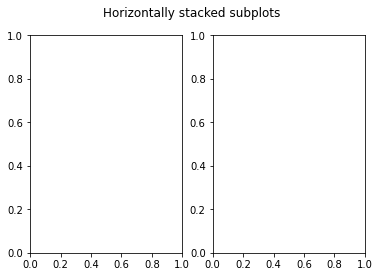

In [37]:
if testing_mode:
    # TODO: Load your saved online_dqn model for evaluation
    # ...
    loaded_pth_file = torch.load(test_model_directory)
    online_dqn = DeepQNet(h,w,image_stack,num_actions)
    online_dqn.load_state_dict(loaded_pth_file['online_dqn'])

    test_metrics = dict(reward=[], loss=[])
    for it in range(max_test_episodes):
        episode_metrics, curr_step = run_episode(curr_step, buffer, is_training=False)
        update_metrics(test_metrics, episode_metrics)
        print_metrics(it + 1, test_metrics, is_training=False)
    plot_metrics(test_metrics)
else:
    train_metrics = dict(reward=[], loss=[])
    for it in range(max_train_episodes):
        episode_metrics, curr_step = run_episode(curr_step, buffer, is_training=True)
        update_metrics(train_metrics, episode_metrics)
        if curr_step > burn_in_phase and eps > min_eps:
            eps *= eps_decay
        if it % 50 == 0:
            print_metrics(it, train_metrics, is_training=True)
            save_checkpoint(curr_step, eps, train_metrics)
        # print(f"episode: {it} done!")
    plot_metrics(train_metrics)